# OpenCV Filters Webcam

In this notebook, several filters will be applied to webcam images.

Those input sources and applied filters will then be displayed either directly in the notebook or on HDMI output.

To run all cells in this notebook a webcam and HDMI output monitor are required.  

## 1. Start HDMI output 
### Step 1: Load the overlay

In [1]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *
base = BaseOverlay("base.bit")

### Step 2: Initialize HDMI I/O

In [2]:
# monitor configuration: 640*480 @ 60Hz
Mode = VideoMode(640,480,24)
hdmi_out = base.video.hdmi_out
hdmi_out.configure(Mode,PIXEL_BGR)
hdmi_out.start()

## 2. Applying OpenCV filters on Webcam input
### Step 1: Specify webcam resolution

In [3]:
# camera (input) configuration
frame_in_w = 640
frame_in_h = 480

### Step 2: Initialize camera from OpenCV

In [4]:
import cv2

videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);
print("capture device is open: " + str(videoIn.isOpened()))

capture device is open: True


### Step 3: Send webcam input to HDMI output

In [5]:
import numpy as np

ret, frame_vga = videoIn.read()

if (ret):
    outframe = hdmi_out.newframe()
    outframe[:] = frame_vga
    hdmi_out.writeframe(outframe)
else:
    raise RuntimeError("Error while reading from camera.")

### Step 4: Edge detection 
Detecting edges on webcam input and display on HDMI out.

In [6]:
import time

num_frames = 20
readError = 0

start = time.time()
for i in range (num_frames):   
    # read next image
    ret, frame_vga = videoIn.read()
    if (ret):
        outframe = hdmi_out.newframe()
        laplacian_frame = cv2.Laplacian(frame_vga, cv2.CV_8U, dst=outframe)
        hdmi_out.writeframe(outframe)
    else:
        readError += 1
end = time.time()

print("Frames per second: " + str((num_frames-readError) / (end - start)))
print("Number of read errors: " + str(readError))

Frames per second: 10.330912534744844
Number of read errors: 0


### Step 5: Canny edge detection
Detecting edges on webcam input and display on HDMI out.

Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity. If they are connected to “sure-edge” pixels, they are considered to be part of edges. Otherwise, they are also discarded. As we only need a single output channel reconfigure the HDMI output to work in grayscale mode. This means that our output frame is in the correct format for the edge detection algorith,

In [7]:
num_frames = 20

Mode = VideoMode(640,480,8)
hdmi_out = base.video.hdmi_out
hdmi_out.configure(Mode,PIXEL_GRAY)
hdmi_out.start()

start = time.time()
for i in range (num_frames):
    # read next image
    ret, frame_webcam = videoIn.read()
    if (ret):
        outframe = hdmi_out.newframe()
        cv2.Canny(frame_webcam, 100, 110, edges=outframe)
        hdmi_out.writeframe(outframe)
    else:
        readError += 1
end = time.time()

print("Frames per second: " + str((num_frames-readError) / (end - start)))
print("Number of read errors: " + str(readError))

Frames per second: 14.89759004370389
Number of read errors: 0


### Step 6: Show results
Now use matplotlib to show filtered webcam input inside notebook.

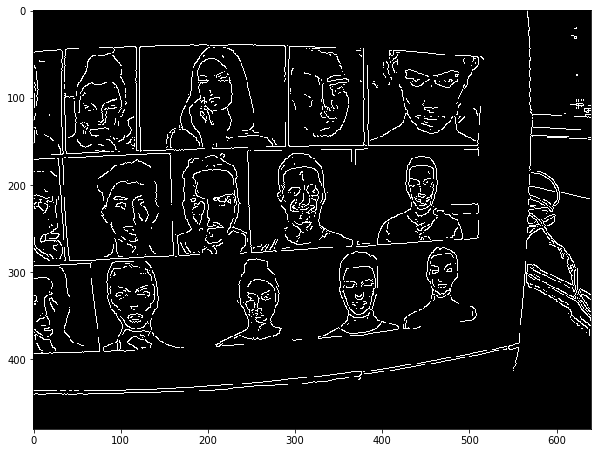

In [8]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np

frame_canny = cv2.Canny(frame_webcam, 100, 110)
plt.figure(1, figsize=(10, 10))
frame_vga = np.zeros((480,640,3)).astype(np.uint8)
frame_vga[:,:,0] = frame_canny
frame_vga[:,:,1] = frame_canny
frame_vga[:,:,2] = frame_canny
plt.imshow(frame_vga)
plt.show()

### Step 7: Release camera and HDMI

In [9]:
videoIn.release()
hdmi_out.stop()
del hdmi_out